In [1]:
!pip install bertopic==0.16.0 datasets==2.16.1 Arabic-Stopwords==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 11.5 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64

In [2]:
from datasets import load_dataset
import pandas as pd
import re
import random
import nltk
nltk.download("punkt")
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
def clean_text(text: str):
    if not isinstance(text, str):
        # raise TypeError("text must be a string")
        return ""

    # remove urls
    text = re.sub(r"http\S+", " رابط ", text)

    # replace any digit with رقم
    text = re.sub(r"\d+", " رقم ", text)

    # set space before and after any punctuation
    text = re.sub(r"([^\w\s])", r" \1 ", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text)

    words = word_tokenize(text)
    text = " ".join([ w for w in words if len(w) > 1 ] )

    return text.lower().strip()

In [4]:
ar_dataset = load_dataset("saudinewsnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/31030 [00:00<?, ? examples/s]

In [5]:
ar_dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'url', 'date_extracted', 'title', 'author', 'content'],
        num_rows: 31030
    })
})

In [6]:
ar_dataset['train'][0]

{'source': 'aawsat',
 'url': 'http://aawsat.com/home/article/410826/بريطانيا-أربعة-محاور-لاستراتيجية-جديدة-تتصدى-للتطرف-على-مدى-خمس-سنوات',
 'date_extracted': '2015-07-21 02:51:32',
 'title': 'بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى للتطرف على مدى خمس سنوات',
 'author': 'لندن: رنيم حنوش',
 'content': 'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام الم

In [7]:
raw_dataset = [
    {
        "text": rec["content"],
        "source": rec["source"],
        "date": rec["date_extracted"]
    }
    for rec in ar_dataset['train']
]

In [8]:
raw_dataset_df = pd.DataFrame( raw_dataset )
raw_dataset_df = raw_dataset_df.sample(frac=1, random_state=42)

In [9]:
raw_dataset_df.head()

,text,source,date
16261,واس – جدة: تلقى خادم الحرمين الشريفين الملك س...,sabq,2015-08-01 07:51:33
28287,لفت وزير العدل أشرف ريفي في تصريح امس «انه لو...,almadina,2015-08-10 19:24:39
21803,عقد مدير الكرة بالمنتخب السعودي زكي الصالح...,alriyadh,2015-08-06 01:13:10
28752,حوادث المعلمات ومعاناتهن في الوصول يومياً إلى...,alwatan,2015-08-10 19:44:53
2772,سبق- جدة: يقدّم الدكتور عبدالرحمن بن رجا الله...,sabq,2015-07-21 02:42:37


In [10]:
raw_dataset_df['text'] = raw_dataset_df['text'].apply(clean_text)

In [11]:
raw_dataset_df['text_len'] = raw_dataset_df['text'].apply(len)

In [12]:
raw_dataset_df.head(2)

,text,source,date,text_len
16261,واس جدة تلقى خادم الحرمين الشريفين الملك سلمان...,sabq,2015-08-01 07:51:33,920
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1884


<Axes: xlabel='text_len', ylabel='Count'>

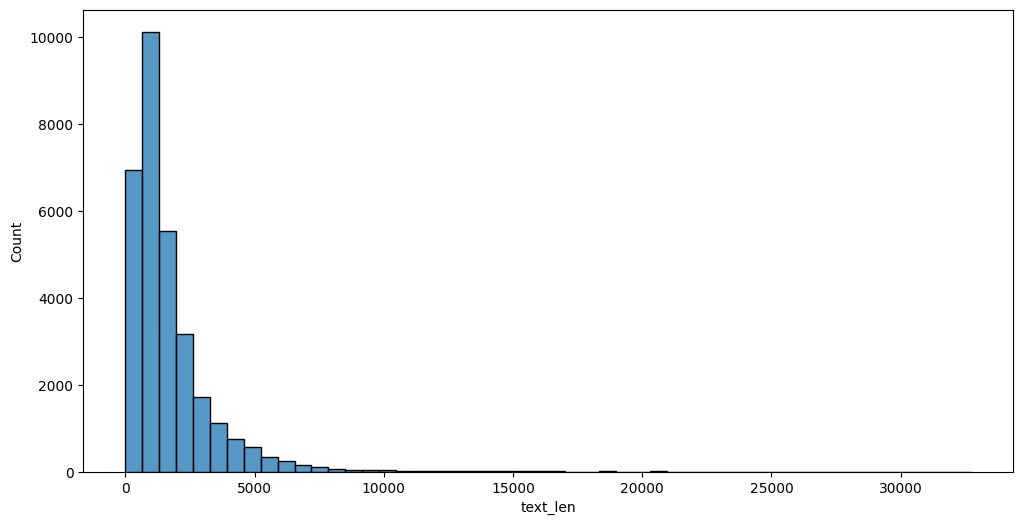

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(raw_dataset_df['text_len'], bins=50)

In [14]:
print(raw_dataset_df.shape)
raw_dataset_df = raw_dataset_df[ raw_dataset_df['text_len'] <= 10_000 ]
print(raw_dataset_df.shape)

(31030, 4)
(30902, 4)


In [15]:
print(raw_dataset_df.shape)
raw_dataset_df.drop_duplicates('text', inplace=True)
print(raw_dataset_df.shape)

(30902, 4)
(29691, 4)


<ipython-input-15-10b5e2ceb2ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset_df.drop_duplicates('text', inplace=True)


In [38]:
raw_dataset_df['datetime_stamp'] = raw_dataset_df['date'].apply(lambda v:datetime.strptime(v,"%Y-%m-%d %H:%M:%S"))

raw_dataset_df['date_stamp'] = raw_dataset_df['datetime_stamp'].apply(lambda v:v.replace(hour=0, minute=0, second=0))

## Embedding

In [17]:
from sentence_transformers import SentenceTransformer

model_id = "sentence-transformers/LaBSE"
embedding_model = SentenceTransformer(model_id, device="cuda:0")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [18]:
news_embeddings = embedding_model.encode(raw_dataset_df.text.values,show_progress_bar=True)

Batches:   0%|          | 0/928 [00:00<?, ?it/s]

In [19]:
news_embeddings.shape

(29691, 768)

## Dim Reduction

In [20]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=15,
                  min_dist=0.0, metric='cosine',
                  random_state=101)

## Clustering

In [21]:
from hdbscan import HDBSCAN

# A higher min_cluster_size will generate fewer topics
# A lower min_cluster_size will generate more topics.

hdbscan_model = HDBSCAN(min_cluster_size=50,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

## Vectorizer

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import arabicstopwords.arabicstopwords as stp

stop_words = stp.stopwords_list()

vectorizer_model = CountVectorizer(min_df=3,
                                   stop_words=stop_words,
                                   analyzer='word',
                                   max_df=0.5,
                                   ngram_range=(1, 3))

## Topic Representer

In [24]:
from bertopic.representation import KeyBERTInspired

key_bertmodel = KeyBERTInspired()
representation_model = {
    "keyBERT":key_bertmodel
}

## Let's Go

In [25]:
from bertopic import BERTopic

topic_model = BERTopic(
    #pipeline models
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model = vectorizer_model,
    representation_model=representation_model,
    # hyper parameters
    top_n_words =10,
    verbose=True
)

topics, probs = topic_model.fit_transform(
    raw_dataset_df.text.values,
    news_embeddings
)

2024-02-20 07:54:14,697 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-20 07:55:36,511 - BERTopic - Dimensionality - Completed ✓
2024-02-20 07:55:36,518 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-20 07:55:47,618 - BERTopic - Cluster - Completed ✓
2024-02-20 07:55:47,638 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-20 07:57:46,137 - BERTopic - Representation - Completed ✓


In [26]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,keyBERT,Representative_Docs
0,-1,9917,-1_مليار_رقم مليار_بنسبة رقم رقم_رقم رقم مليار,"[مليار, رقم مليار, بنسبة رقم رقم, رقم رقم مليا...","[الملك سلمان عبدالعزيز, عبدالعزيز آل سعود, سلم...",[قال نائب خادم الحرمين الشريفين الأمير محمد بن...
1,0,4083,0_القدم_النادي_الموسم_اللاعب,"[القدم, النادي, الموسم, اللاعب, اللاعبين, لكرة...","[الموسم المقبل, اللاعبين, الموسم الماضي, لاعبي...",[تستعد منافسات الكرة الأوروبية للانطلاق معلنة ...
2,1,668,1_إيران_الاتفاق_النووي_الإيراني,"[إيران, الاتفاق, النووي, الإيراني, الاتفاق الن...","[الاتفاق النووي الإيراني, الاتفاق النووي إيران...",[دافع محمد جواد ظريف وزير الخارجية الإيراني عن...
3,2,643,2_بشرطة_التحقيق_القبض_التحرش,"[بشرطة, التحقيق, القبض, التحرش, الجهات الأمنية...","[مقطع فيديو, عاطي عطية القرشي, الفيديو, مقطع ا...",[عبدالله البرقاوي سبق الطائف أوضح الناطق الإعل...
4,3,614,3_المقاومة_عدن_الحوثيين_الحوثي,"[المقاومة, عدن, الحوثيين, الحوثي, الشعبية, الم...","[الحوثيين وقوات صالح, الحوثيين وقوات, عدن, محا...",[وصلت أمس الأحد تجهيزات عسكرية مقدمة من دول ال...
...,...,...,...,...,...,...
89,88,59,88_حرس_حرس الحدود_البحث والإنقاذ_والإنقاذ,"[حرس, حرس الحدود, البحث والإنقاذ, والإنقاذ, ال...","[فرق البحث والإنقاذ, البحث والإنقاذ, والإنقاذ,...",[باشرت فرق البحث والإنقاذ في قطاعات حرس الحدود...
90,89,59,89_الفندق_المطعم_مطعم_الطعام,"[الفندق, المطعم, مطعم, الطعام, فندق, الأطباق, ...","[سلسلة مطاعم, لندن, london, المطعم, الملكة إلي...",[أن تنعم بالهواء النقي والطعام الشهي في قلب حد...
91,90,57,90_الجمارك_تهريب_جمرك_رجال الجمارك,"[الجمارك, تهريب, جمرك, رجال الجمارك, مخبأة, مد...","[إحباط محاولة تهريب, محاولة تهريب, مطار الملك ...",[إبراهيم الحذيفي عين اليوم تمكن رجال الجمارك ب...
92,91,51,91_الحملة_السوريين_الوطنية السعودية_الأشقاء,"[الحملة, السوريين, الوطنية السعودية, الأشقاء, ...","[للأشقاء اللاجئين السوريين, اللاجئين السوريين,...",[أنهت الحملة الوطنية السعودية المرحلة الثالثة ...


In [27]:
raw_dataset_df.text.values[50]

'افتتح مدير عام الشؤون الصحية بمنطقة تبوك الصيدلي محمد الطويلعي وحدتي العناية المركزة والعزل بمستشفى الملك فهد بتبوك إضافة لعيادتي الأمراض التنفسية وفحص النساء وأوضح مدير مستشفى الملك فهد بتبوك سليمان علي أبوذراع أنه تم إنشاء وحدة عناية مركزة جديدة مجهزة بأحدث المواصفات بجانب تدعيمها الكامل بما يلزم من كوادر طبية وفنية لتسهم مع مستشفيات المنطقة في تقديم أفضل الخدمات الصحية مشيرا إلى أنه تم استحداث وحدة عزل داخل قسم الطوارئ خاصة بمرضى متلازمة الشرق الأوسط التنفسية كورونا مجهزة بجميع التجهيزات والفلاتر التي تضمن سلامة المريض والعاملين إضافة لاستحداث وحدة فحص خاصة بالنساء وتوسعة قاعة التدريب والتعليم بالمستشفى'

In [28]:
topics[50] , probs[50]

(39, 1.0)

In [29]:
raw_dataset_df['topic'] = topics
raw_dataset_df['probs'] = probs

In [30]:
topic_model.get_topic(17)

[('الطفلة', 0.04088345248026149),
 ('المستشفى', 0.037012771842524876),
 ('الطبي', 0.012241389988002333),
 ('المريض', 0.01187427274560165),
 ('بمستشفى', 0.011792536467288542),
 ('الشؤون الصحية', 0.01121541755159147),
 ('الطبيب', 0.010756918262288173),
 ('المتوفاة', 0.010477360047952865),
 ('العناية', 0.010249310249779245),
 ('العلاج', 0.009895965159329475)]

In [31]:
raw_dataset_df[raw_dataset_df.topic == 17].head(10)

,text,source,date,text_len,datetime_stamp,topic,probs
2867,بدر الجبل سبق تبوك ناشد رجل أمن متقاعد برتبة ج...,sabq,2015-07-21 02:44:21,773,2015-07-21 02:44:21,17,0.534229
11398,سبق الجوف واصل مستشفى الأمير متعب بن عبدالعزيز...,sabq,2015-07-26 16:46:56,1396,2015-07-26 16:46:56,17,0.520286
14962,سبق وكالات إهمال طبيب ألماني في إرسال سيدة حية...,sabq,2015-07-31 04:38:54,910,2015-07-31 04:38:54,17,0.360505
4900,من يصدق أن جثة مريض يمكن أن تبقى في غرفة الطوا...,okaz,2015-07-22 10:38:39,1931,2015-07-22 10:38:39,17,1.000000
11960,أوضحت سفارة خادم الحرمين الشريفين لدى سلطنة عم...,almadina,2015-07-27 18:49:28,723,2015-07-27 18:49:28,17,0.365185
14655,أقرت الشؤون الصحية بالعاصمة المقدسة بحدوث تسري...,okaz,2015-07-31 03:54:21,998,2015-07-31 03:54:21,17,1.000000
11417,بدر الجبل سبق تبوك وج أمير منطقة الرياض فيصل ب...,sabq,2015-07-26 22:31:38,592,2015-07-26 22:31:38,17,0.374926
8364,فهد الغبيوي سبق الدوادمي أوضحت إدارة مستشفى ال...,sabq,2015-07-24 08:46:39,579,2015-07-24 08:46:39,17,0.622008
9971,حنان الحامدي متابعات اضطرت عروس لم يمض على زوا...,3alyoum,2015-07-26 17:10:30,701,2015-07-26 17:10:30,17,0.472783
14578,فوجئ مرضى ومراجعو مستشفى الملك فهد الجامعي بال...,alyaum,2015-07-31 04:24:09,895,2015-07-31 04:24:09,17,0.456491


In [32]:
topic_model.visualize_topics()

In [34]:
topic_model.visualize_heatmap()

In [35]:
topic_per_class = topic_model.topics_per_class(
    raw_dataset_df.text.values,
    classes=raw_dataset_df.source.values,
)

14it [00:41,  2.98s/it]


In [36]:
topic_model.visualize_topics_per_class(topic_per_class,top_n_topics=20)

In [39]:
topics_over_time = topic_model.topics_over_time(
    raw_dataset_df.text.values,
    raw_dataset_df.date_stamp.values
)

18it [02:04,  6.91s/it]


In [40]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)

In [42]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df.text.values
)

100%|██████████| 92/92 [00:01<00:00, 54.11it/s]


In [43]:
topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

In [45]:
topics_to_merge = [
    [84, 32],
    [92, 59, 7]
]

In [46]:
topic_model.merge_topics(
    raw_dataset_df.text.values,
    topics_to_merge
                         )

In [47]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df.text.values
)

100%|██████████| 89/89 [00:01<00:00, 74.58it/s]


In [48]:
topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

In [49]:
raw_dataset_df.head()

,text,source,date,text_len,datetime_stamp,topic,probs,date_stamp
16261,واس جدة تلقى خادم الحرمين الشريفين الملك سلمان...,sabq,2015-08-01 07:51:33,920,2015-08-01 07:51:33,-1,0.000000,2015-08-01
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1884,2015-08-10 19:24:39,30,0.332821,2015-08-10
21803,عقد مدير الكرة بالمنتخب السعودي زكي الصالح مسا...,alriyadh,2015-08-06 01:13:10,1196,2015-08-06 01:13:10,0,1.000000,2015-08-06
28752,حوادث المعلمات ومعاناتهن في الوصول يوميا إلى م...,alwatan,2015-08-10 19:44:53,2702,2015-08-10 19:44:53,18,1.000000,2015-08-10
2772,سبق جدة يقد الدكتور عبدالرحمن بن رجا الله السل...,sabq,2015-07-21 02:42:37,716,2015-07-21 02:42:37,56,1.000000,2015-07-21


In [52]:
filtered_raw_dataset_df = raw_dataset_df[~raw_dataset_df.topic.isin([-1])]

In [53]:
filtered_raw_dataset_df.head()

,text,source,date,text_len,datetime_stamp,topic,probs,date_stamp
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1884,2015-08-10 19:24:39,30,0.332821,2015-08-10
21803,عقد مدير الكرة بالمنتخب السعودي زكي الصالح مسا...,alriyadh,2015-08-06 01:13:10,1196,2015-08-06 01:13:10,0,1.000000,2015-08-06
28752,حوادث المعلمات ومعاناتهن في الوصول يوميا إلى م...,alwatan,2015-08-10 19:44:53,2702,2015-08-10 19:44:53,18,1.000000,2015-08-10
2772,سبق جدة يقد الدكتور عبدالرحمن بن رجا الله السل...,sabq,2015-07-21 02:42:37,716,2015-07-21 02:42:37,56,1.000000,2015-07-21
14826,من المسائل التي من الله بها على المرأة دون الر...,okaz,2015-07-31 12:21:44,1055,2015-07-31 12:21:44,10,0.633850,2015-07-31


## inference

In [54]:
story = """
طرحت مؤسسة البترول الكويتية عطاءً؛ لبيع زيت وقود عالي الكبريت للتحميل في الفترة من فبراير/ شباط إلى إبريل/ نيسان.
وأوضحت مصادر تجارية، اليوم الخميس، أن المؤسسة تعرض شحنات من زيت الوقود عالي الكبريت تبلغ الواحدة 60 ألف طن لتحميلها من الكويت شهرياً بالفترة المذكورة.
"""


_topic, _prob = topic_model.transform([story])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-20 08:42:57,895 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-02-20 08:43:38,747 - BERTopic - Dimensionality - Completed ✓
2024-02-20 08:43:38,756 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-02-20 08:43:38,758 - BERTopic - Cluster - Completed ✓


In [55]:
_topic, _prob

([8], array([0.81728631]))

In [56]:
topic_model.get_topic(_topic[0])

[('النفط', 0.05533373800069787),
 ('برميل', 0.03206886744693083),
 ('الخام', 0.0280228924564241),
 ('للبرميل', 0.02406201874608722),
 ('رقم دولار', 0.02059704059853885),
 ('أسعار النفط', 0.019814011214195272),
 ('رقم رقم دولار', 0.019527908544177183),
 ('مليون برميل', 0.018972511436998768),
 ('برميل يوميا', 0.017708169071060764),
 ('رقم مليون برميل', 0.01746733565862383)]

In [58]:
filtered_raw_dataset_df[filtered_raw_dataset_df.topic == _topic[0]].head()

,text,source,date,text_len,datetime_stamp,topic,probs,date_stamp
19924,تعافى النفط إلى أعلى قليلا من رقم دولارا للبرم...,alweeam,2015-08-04 18:13:36,1270,2015-08-04 18:13:36,8,1.000000,2015-08-04
13010,عين اليوم سنغافورة تراجعت أسعار النفط في التعا...,3alyoum,2015-07-31 12:13:39,1702,2015-07-31 12:13:39,8,0.998249,2015-07-31
20723,صرح علي رضا ناطقي مسؤول تأسيس الغرف التجارية ا...,aawsat,2015-08-06 08:11:36,1156,2015-08-06 08:11:36,8,0.625333,2015-08-06
29367,عين اليوم جدة تراجعت أسعار النفط اليوم الثلاثا...,3alyoum,2015-08-11 13:45:50,1136,2015-08-11 13:45:50,8,0.769622,2015-08-11
15268,قالت إدارة معلومات الطاقة الأمريكية في بيانات ...,aleqtisadiya,2015-08-01 08:04:42,3815,2015-08-01 08:04:42,8,1.000000,2015-08-01


## Save and Load

In [59]:
model_id = "sentence-transformers/LaBSE"

topic_model.save("/content/safe_bertopic", serialization='safetensors',
                 save_ctfidf=True, save_embedding_model=model_id)


In [60]:
loaded_model = BERTopic.load("/content/safe_bertopic")